# Airbnb Data Modeling

Model predict airbnb day prices in Seattle using feature engineering, feature selection techniques  and light gradient boosting regression.

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMModel
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import SGDRegressor
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from scipy.sparse import hstack
MAX_FEAT_DESCP = 70

In [44]:
df=pd.read_csv("listings_seattle.csv")
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,2.016010e+13,1/4/2016,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,2.016010e+13,1/4/2016,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,2.016010e+13,1/4/2016,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,2.016010e+13,1/4/2016,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,2.016010e+13,1/4/2016,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


Model evaluation function fits training data, predicts and computes score

In [45]:
def model_eval(X, y, model):
    '''
    input: X is features data frame, y is respones, model
    output: cross validation score, test score, predicted values
    
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, np.ravel(y_train))
    y_pred = model.predict(X_test)
    score = cross_val_score(model, X_train, y_train, scoring = 'r2', cv =3)
    test_score = r2_score(y_test, y_pred)
    return score, test_score, y_pred

In [46]:
num_rows = df.shape[0] #Provide the number of rows in the dataset
num_cols = df.shape[1] #Provide the number of columns in the dataset
print(num_rows)
print(num_cols)

3818
92


Columns with nulls

In [47]:
nulls = set(df.columns[df.isnull().any()])#Provide a set of columns with missing values.
print(nulls)

{'beds', 'transit', 'cleaning_fee', 'host_thumbnail_url', 'review_scores_cleanliness', 'monthly_price', 'host_response_rate', 'notes', 'medium_url', 'host_since', 'zipcode', 'summary', 'reviews_per_month', 'review_scores_rating', 'xl_picture_url', 'review_scores_checkin', 'review_scores_communication', 'square_feet', 'property_type', 'review_scores_accuracy', 'host_neighbourhood', 'host_about', 'host_picture_url', 'review_scores_location', 'security_deposit', 'host_has_profile_pic', 'license', 'host_name', 'host_is_superhost', 'host_listings_count', 'host_location', 'weekly_price', 'host_identity_verified', 'thumbnail_url', 'host_response_time', 'host_total_listings_count', 'neighborhood_overview', 'bathrooms', 'host_acceptance_rate', 'last_review', 'bedrooms', 'space', 'first_review', 'review_scores_value', 'neighbourhood'}


Columns with many missing values

In [48]:
most_missing_cols = set(df.columns[abs(df.isnull().sum())>0.7*len(df)])
print(most_missing_cols)
df=df.drop(most_missing_cols, axis=1)

{'square_feet', 'license'}


Check what is instant bookable 

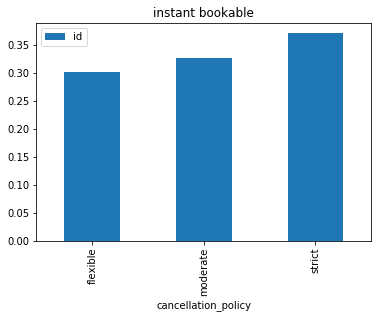

In [49]:
#print(dfb.cancellation_policy.unique())
dfc=df[['id', 'cancellation_policy']].groupby(['cancellation_policy']).count()
(dfc/df.shape[0]).plot(kind="bar");
plt.title("instant bookable");

Columns related to price

In [50]:
out=['price', 'weekly_price', 'monthly_price']

In [51]:
dfm=df.loc[~df['monthly_price'].isnull()]
print(len(dfm))
dfw=df.loc[~df['weekly_price'].isnull()]
print(len(dfw))
print(len(df.loc[~df['price'].isnull()]))

1517
2009
3818


In [52]:
df['price']=df['price'].apply(lambda x: float(x[1:].replace(',','')))


In [53]:
#dfb['review_scores_value']=dfb['review_scores_value'].fillna(0.0)#dfb['review_scores_value'].mean()
#print(dfb['review_scores_value'])
#dfb["host_total_listings_count"].fillna(dfb["host_total_listings_count"].mean())
print(len(df[df["host_total_listings_count"].isnull()]))
col_reviews=['review_scores_value', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location']
col_num = ['host_total_listings_count', 'bedrooms', 'bathrooms', 'beds']
# Mean function
fill_mean = lambda col: col.fillna(col.mean())
# Fill the mean
df[col_num] = df[col_num].apply(fill_mean, axis=0)

for i in col_reviews:
    df[i]=df[i].fillna(0.0)
#for i in col_num:
 #   dfb[i]=dfb[i].fillna(dfb[i].mean())
#print(dfb[col_num])

2


In [54]:
colf=df.select_dtypes(['float', 'int']).columns
colf =[i for i in colf if i not in ['scrape_id']]
print(colf)
#print(dfb.loc[dfb['monthly_price'].isnull(), ['monthly_price']])

['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']


In [55]:
df["host_total_listings_count"]=df["host_total_listings_count"].fillna(df["host_total_listings_count"].mean())
print(len(df[df["host_total_listings_count"].isnull()]))
col_num_cor = ['host_total_listings_count', 'bedrooms', 'bathrooms', 'beds', 'square_feet', 'review_scores_value', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_location']


0


['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
['host_total_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_checkin', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
11
all
numerical
[0.52583605 0.55736217 0.58527435]
0.5861763666919348
Plot feature importances…


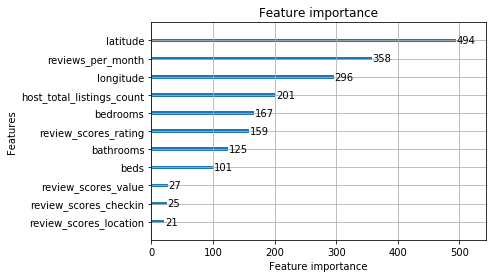

In [56]:
print(colf)
#colf=np.append(colf,['description'])
col = [i for i in colf if i not in ['review_scores_communication', 'review_scores_cleanliness',  'review_scores_accuracy','host_listings_count',"price"]]
print(col)
#df['beds']=df['beds'].astype('category')
#['bedrooms']=df['bedrooms'].astype('category')
X_num=df[col]
#X=np.concatenate((X_num, X_cat),axis =0)
Y=df["price"]
#model
print(len(col))
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.05, num_leaves=42, max_depth =5)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#XGBClassifier(max_depth=5, learning_rate=0.01,  sample_weight=w_array)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
#model=XGBRegressor(max_depth=5, learning_rate=0.05)
#cross_lval
score, test_score, y_pred = model_eval(X_num, Y, model)
print('all')
print('numerical')
print(score)
print(test_score)
print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=20)
plt.show()

In [57]:
df=df.drop(['experiences_offered'], axis=1)

In [58]:
#print(df['host_is_superhost'])
cat_col = df.select_dtypes(include=['object']).columns
df[cat_col] = df[cat_col].fillna('none')
text=[ 'amenities', 'name', 'notes', 'description', 'neighborhood_overview', 'transit', 'host_about']
exclude=['instant_bookable','host_identity_verified','is_location_exact','review_scores_cleanliness','require_guest_profile_picture', 'require_guest_phone_verification', 'security_deposit', 'calendar_last_scraped', 'calendar_updated', 'cleaning_fee','extra_people','host_since','first_review', 'last_review','market','listing_url', 'country', 'space', 'thumbnail_url', 'city', 'state', 'medium_url',  'host_has_profile_pic', 'host_thumbnail_url', 'country_code','host_url', 'host_name', 'description', 'last_scraped', 'picture_url', 'xl_picture_url', 'summary', 'host_picture_url']
cat_col = [i for i in cat_col if i not in out+exclude+text]
print(cat_col)
le  = LabelEncoder()
for i in cat_col:
    df[i]=le.fit_transform(df[i].astype('category'))
X_cat = df[cat_col]

['host_location', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood', 'host_verifications', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'zipcode', 'smart_location', 'property_type', 'room_type', 'bed_type', 'has_availability', 'requires_license', 'jurisdiction_names', 'cancellation_policy']


['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
['host_total_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_checkin', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
11
all
numerical
[0.56314649 0.56871998 0.61868191]
0.6251409545616655
Plot feature importances…


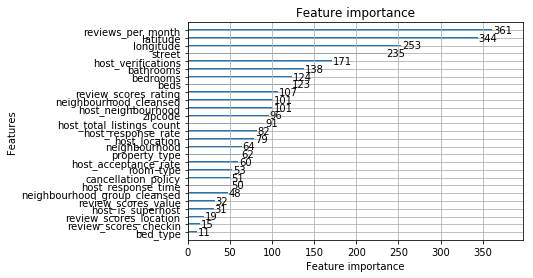

In [59]:
print(colf)
print(col)
Y=df["price"]
#model
print(len(col))
#model
X=df[col+cat_col]
model = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.1, num_leaves=42, max_depth =7)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
#model=XGBRegressor(max_depth=5, learning_rate=0.05)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
#cross_val
score, test_score, y_pred = model_eval(X, Y, model)
print('all')
print('numerical')
print(score)
print(test_score)

print("Plot feature importances…")
ax = lgb.plot_importance(model, max_num_features=31)
plt.show()

In [60]:
count_descp = TfidfVectorizer(max_features = 90, 
                              ngram_range = (1,3),
                              stop_words = "english")
count_am = TfidfVectorizer(max_features = 50, 
                              ngram_range = (1,3),
                              stop_words = "english")
count_transit = TfidfVectorizer(max_features = 50, 
                              ngram_range = (1,3),
                              stop_words = "english")
X_desc = count_descp.fit_transform(df["description"])
X_name = count_descp.fit_transform(df["name"])
X_transit = count_transit.fit_transform(df["transit"])
X_am = count_am.fit_transform(df['amenities'])

['host_listings_count', 'host_total_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
['host_total_listings_count', 'latitude', 'longitude', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'review_scores_checkin', 'review_scores_location', 'review_scores_value', 'reviews_per_month']
all
numerical
[0.23313017 0.28111158 0.27143095]
0.33986990974254305
0.6251409545616655
Plot feature importances…


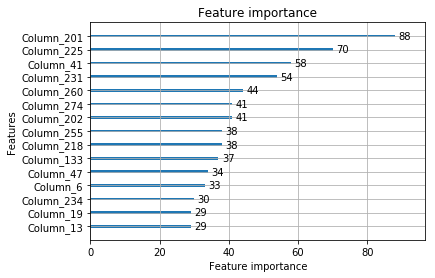

In [61]:
print(colf)
#colf=np.append(colf,['description'])
#col = [i for i in colf if i != "price"]
print(col)
X_desc
#X_num=df[col]
#X_cat=df[cat_col].astype('category')
#X=np.concatenate((X_num, X_desc),axis =1)
Y=df["price"]
#model
X1=hstack((              X_am,
                         X_transit,      
                         X_name,
                         X_desc)).tocsr()
model1 = lgb.LGBMRegressor(boosting_type ='gbdt', learning_rate = 0.2, num_leaves=43, max_depth = 9)#DecisionTreeClassifier(min_samples_split=4, max_depth=8,  class_weight={0: 1, 1: 4})#
#model=XGBRegressor(max_depth=6, learning_rate=0.05, early_stopping_rounds=20)#DecisionTreeClassifier(max_depth=5,  class_weight={0: 1, 1: 3.5}) #ExtraTreesClassifier(n_estimators=100, max_depth=5)
#score, test_score, ypred = model_eval(X, Y, model1)
score1, test_score1, ypred1 = model_eval(X1, Y, model1)
print('all')
print('numerical')
#print(score)
print(score1)
print(test_score1)
y_pred2=0.2*ypred1+0.8*y_pred
#y_pred=0.2*model1.predict(X1)+0.8*model.predict(X)
#test_score = r2_score(y_test, y_pred2)
print(test_score)
print("Plot feature importances…")
ax = lgb.plot_importance(model1, max_num_features=15)
plt.show()